http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/

In [32]:
import numpy as np
import scipy as sp
import pandas as pd
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import functools

import plotly
import plotly.graph_objs as go
import string
import numpy as np
import random

from scipy.stats import norm
from __future__ import print_function

%matplotlib inline
plotly.offline.init_notebook_mode() 
sns.set_style('white')
sns.set_context('talk')
np.random.seed(123)

** Ahora vamos a proponer un conjunto de datos y un modelo.   Los datos serán generados a partir del modelo, con un agregado de ruido, de manera que sabemos de entrada cuáles con los parámetros a obtener e intentaremos contruir una MCMC para obtener una estimación de esos parámetros.  Este modelo "de juguete" representa por ejemplo la curva de luz de una supernova, y tiene dos parámetros: $\alpha$ y $t_0$ (un tercer parámetro que da la amplitud no se incluye por simplicidad). **

### Likelihood:

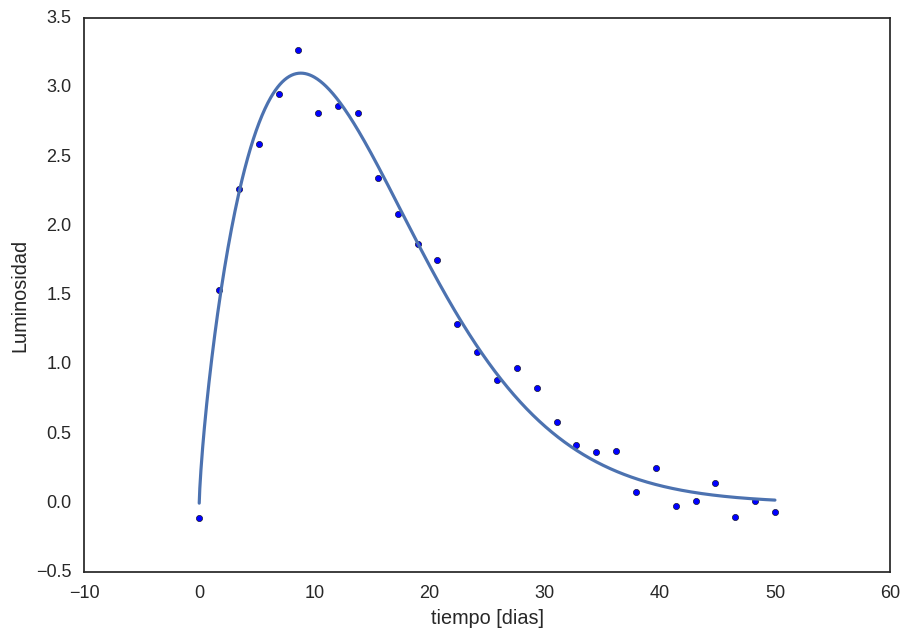

In [33]:
def MODEL(t, a0, t0):
    y = t**(a0)*np.exp(-(t/t0)**1.5)
    return(y)
    
Ndat = 30
NoiseSD = 10.

a0_real = 3./4.
t0_real = 14.

modelx = np.linspace(0, 50, Ndat)
modely = MODEL(modelx, a0_real, t0_real)
r = [np.random.randn()/NoiseSD for _ in range(Ndat)]
obsx = modelx
obsy = modely + r

sx = np.linspace(0, 50, 1000)
sy = MODEL(sx, a0_real, t0_real)

# Plot it!
plt.plot(sx,sy, "-")
plt.scatter(obsx,obsy)
plt.xlabel('tiempo [dias]')
plt.ylabel('Luminosidad')
plt.show()

Veamos primero cómo cambia el modelo con los parámetros:

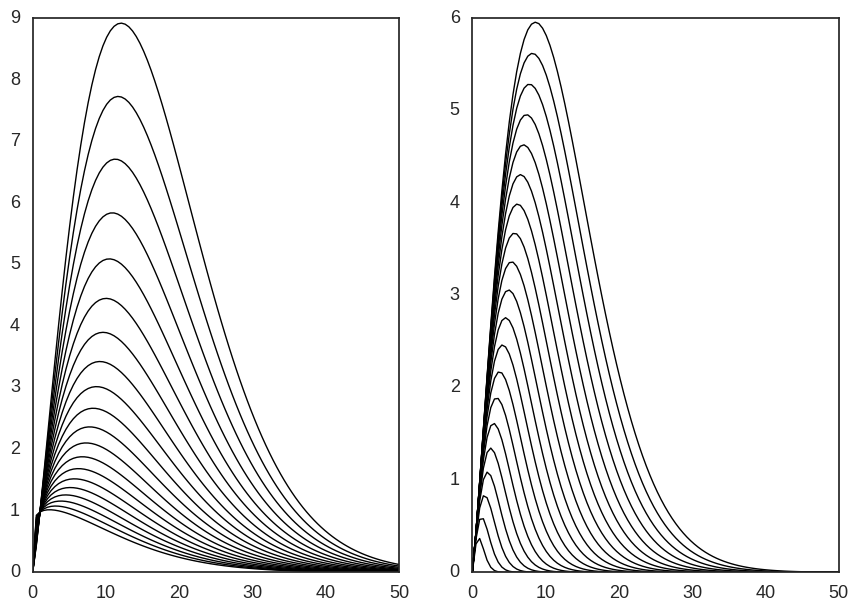

In [35]:
x = np.linspace(0, 50, 100)
a0 = 3./4.
t0 = 14.

a0_list = np.linspace(0.1, 1.2, 20)
t0_list = np.linspace(1., 10., 20)

f, (ax1, ax2) = plt.subplots(1,2)
t0 = 14.
for a0 in a0_list:
    y = MODEL(x, a0, t0)
    ax1.plot(x,y, "-",color='k', lw=1)

    alpha = 3./4.
for t0 in t0_list:
    y = MODEL(x, a0, t0)
    ax2.plot(x,y, "-",color='k', lw=1)

plt.show()

Ahora, supongamos que tenemos los datos y queremos calcular el Likelihood.

$$\large P(\,datos\, |\, modelo\,) = L((\vec{x}, \vec{y}) \,|\, a_0, t_0) = \prod_{i=1}^{Ndata} \frac{exp\left[-\left(y_i-M(y_{i}; a_0, t_0)\right)^2\right]}{\sigma_i^2}$$

Como no conocemos los errores, vamos a tomar $\sigma_i=cte=1.$

In [36]:
def LIKELIHOOD(datax, datay, a0, t0):
    modely = MODEL(datax, a0, t0)
    residuos = datay - modely
    ll = 1.
    for r in residuos:
        ll = ll * np.exp(-r**2)
    return(ll)

### Priors:

In [37]:
def step2d(x, y, xmin, xmax, ymin, ymax):
    normalization = (xmax - xmin)*(ymax - ymin)
    y = 1. * (x < xmax) * (x > xmin) * (y < ymax) * (y > ymin)
    y = y / normalization
    return(y)

# Por ejemplo:
print (step2d(0.2, 0.5, -3., 3., -3., 3.))
print (step2d(5., 2., -3, 3., -3., 3.))

# Ahora definimos la funcion de PRIORS como una funcion Top Hat bidimensional
PRIOR = functools.partial(step2d, xmin=0., xmax=3., ymin=0., ymax=20.)

# La funcion de PRIOR tiene dos argumentos, que son los dos parámetros:
print (PRIOR(1., 2.))

0.0277777777778
0.0
0.0166666666667


### Posterior:

In [38]:
def POSTERIOR(datax, datay, a0, t0):    
    posterior = LIKELIHOOD(datax, datay, a0, t0) * PRIOR(a0, t0)
    return(posterior)

### Proposal:

In [39]:
#np.random.multivariate_normal(mean=[0., 0.], cov=[[0.2, 0], [0, 0.2]])

sig_a0 = 2.
sig_t0 = 2.
PROPOSAL = functools.partial(np.random.multivariate_normal, cov = [[sig_a0, 0], [0, sig_t0]] )
# Por ejemplo, se usa así:
PROPOSAL([2., 1.])

array([ 1.63849962, -2.95780267])

## MCMC

1) Proponer valores iniciales para los parámetros y visualizar el modelo propueso

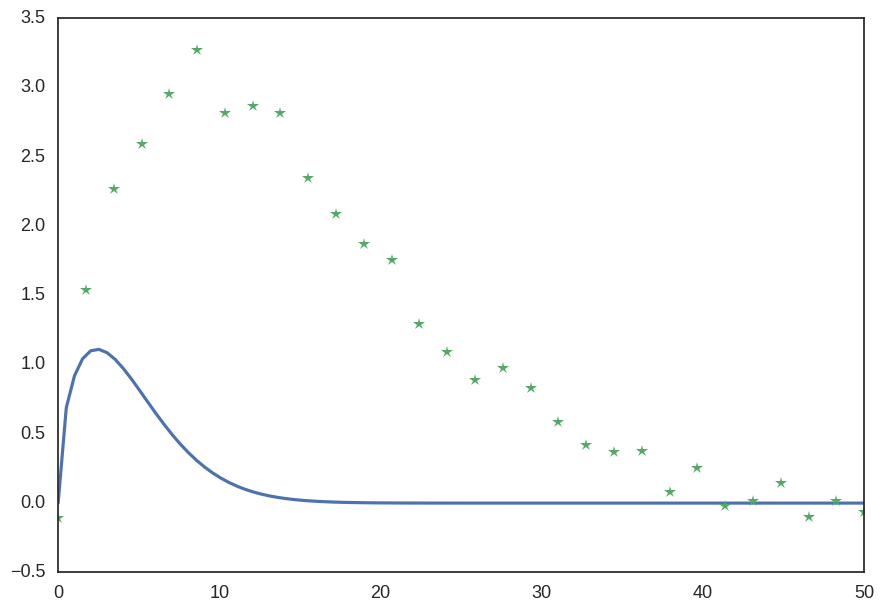

In [40]:
a0_first = 0.5 # Valor inicial para a0
t0_first = 5.  # Valor inicial para t0

# veamos si estamos cerca:
modelx = np.linspace(0, 50, 100)
modely = MODEL(modelx, a0_first, t0_first)
plt.plot(modelx,modely, "-")
plt.plot(obsx,obsy, "*")
plt.show()

2) Establecer los parámetros de la cadena

In [41]:
Nsteps = 5000 # Nro. de pasos
Nburnt = 500

# Set the proposal function
sig_a0 = 0.02
sig_t0 = 0.5
PROPOSAL = functools.partial(np.random.multivariate_normal, cov = [[sig_a0, 0], [0, sig_t0]] )

3) Correr la cadena:

In [42]:
par_a0 = []; par_t0 = []
a0_actual = a0_first
t0_actual = t0_first
post_actual = POSTERIOR(obsx, obsy, a0_actual, t0_actual)

par_a0.append(a0_actual)
par_t0.append(t0_actual)
    
for _ in range(Nsteps):
    
    a0_candid, t0_candid = PROPOSAL([a0_actual, t0_actual])    
    post_candid = POSTERIOR(obsx, obsy, a0_candid, t0_candid)
    
    p_accept = min(1., post_candid / post_actual)
    accept = np.random.rand() < p_accept
    if accept:
        # Update position
        a0_actual = a0_candid
        t0_actual = t0_candid
        post_actual = POSTERIOR(obsx, obsy, a0_actual, t0_actual)
    
    par_a0.append(a0_actual)
    par_t0.append(t0_actual)

par_a0_out = par_a0[:Nburnt]
par_t0_out = par_t0[:Nburnt]
par_a0_brn = par_a0[Nburnt:]
par_t0_brn = par_t0[Nburnt:]

a0_est = np.mean(par_a0)
t0_est = np.mean(par_t0)

4) graficar los resultados

[]

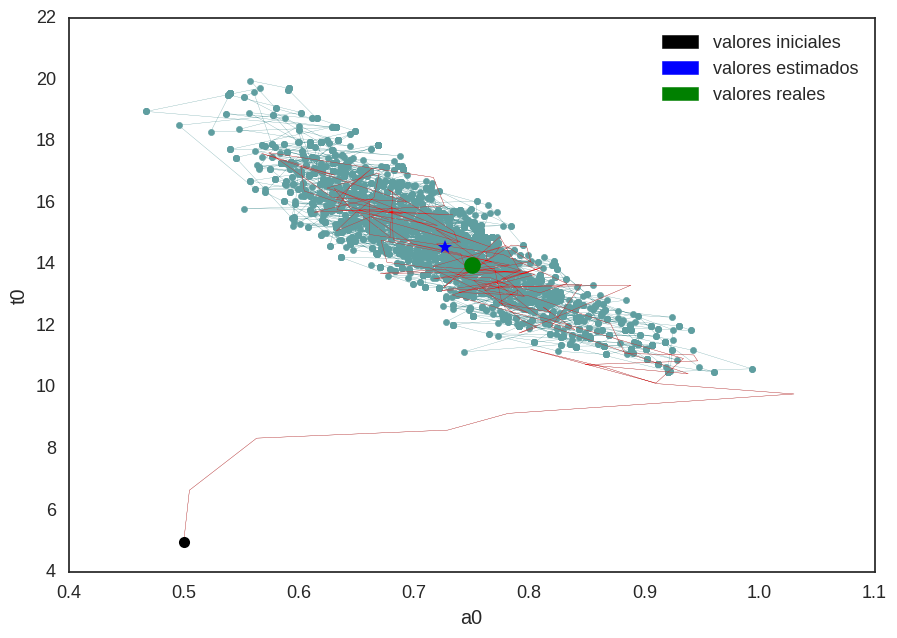

In [43]:
plt.plot(par_a0, par_t0, marker='.', markersize=0., lw = 0.2, color='cadetblue')
plt.plot(par_a0_out, par_t0_out, marker='.', markersize=0., lw = 0.2, color='red')
plt.scatter(par_a0_brn, par_t0_brn, color='cadetblue')
plt.plot(a0_first, t0_first, marker='o', markersize=8, color='k')
plt.plot(a0_real, t0_real, marker='o', markersize=12, color='g')
plt.plot(a0_est, t0_est, marker='*', markersize=10, color='b')
plt.xlabel('a0')
plt.ylabel('t0')
init = mpatches.Patch(color='k', label='valores iniciales')
real = mpatches.Patch(color='g', label='valores reales')
esti = mpatches.Patch(color='b', label='valores estimados')
plt.legend(handles=[init, esti, real])
plt.plot()

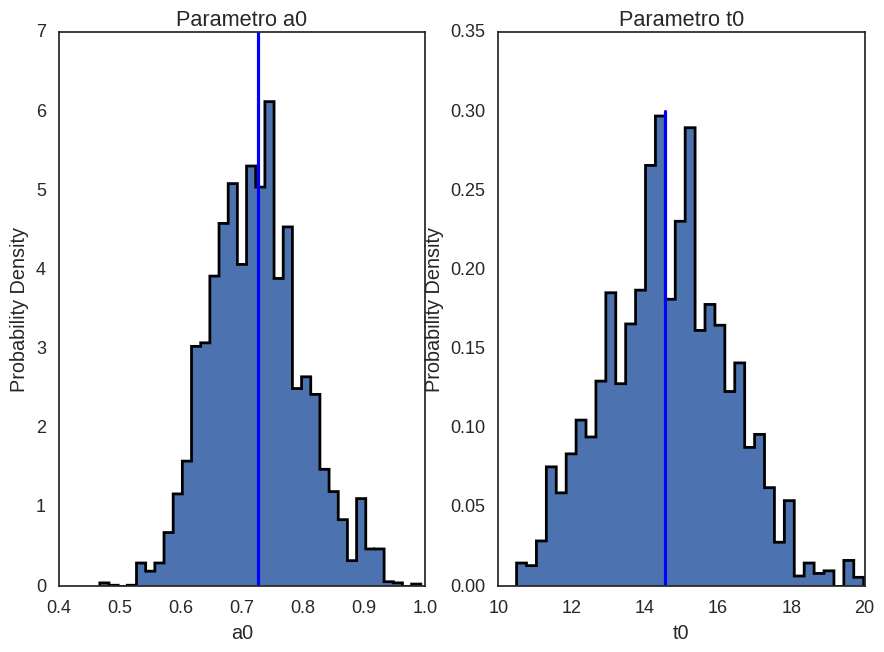

Los valores reales de parámetros son: a0=0.75,  t0=14.00
Las estimaciones de los parámetros son: a0=0.73,  t0=14.55
Los valores iniciales de parámetros son: a0=0.50,  t0=5.00


In [44]:
f, (ax1, ax2) = plt.subplots(1,2)
nb = np.int(np.sqrt(len(par_a0))/2.)
ax1.hist(par_a0_brn, bins=nb, normed=True, histtype='step', color='k', fill=True, lw=2)
ax1.set(xlabel='a0', ylabel='Probability Density', title='Parametro a0')
ax1.plot([a0_est] * 2, [0, ax1.get_ylim()[1]], color='b')

ax2.hist(par_t0_brn,bins=nb,histtype='step',normed=True, color='k', fill=True, lw=2)
ax2.set(xlabel='t0', ylabel='Probability Density', title='Parametro t0')
ax2.plot([t0_est] * 2, [0, ax2.get_ylim()[1]], color='b')
plt.show()

print ('Los valores reales de parámetros son: a0=%.2f,  t0=%.2f' % (a0_real, t0_real))
print ('Las estimaciones de los parámetros son: a0=%.2f,  t0=%.2f' % (a0_est, t0_est))
print ('Los valores iniciales de parámetros son: a0=%.2f,  t0=%.2f' % (a0_first, t0_first))

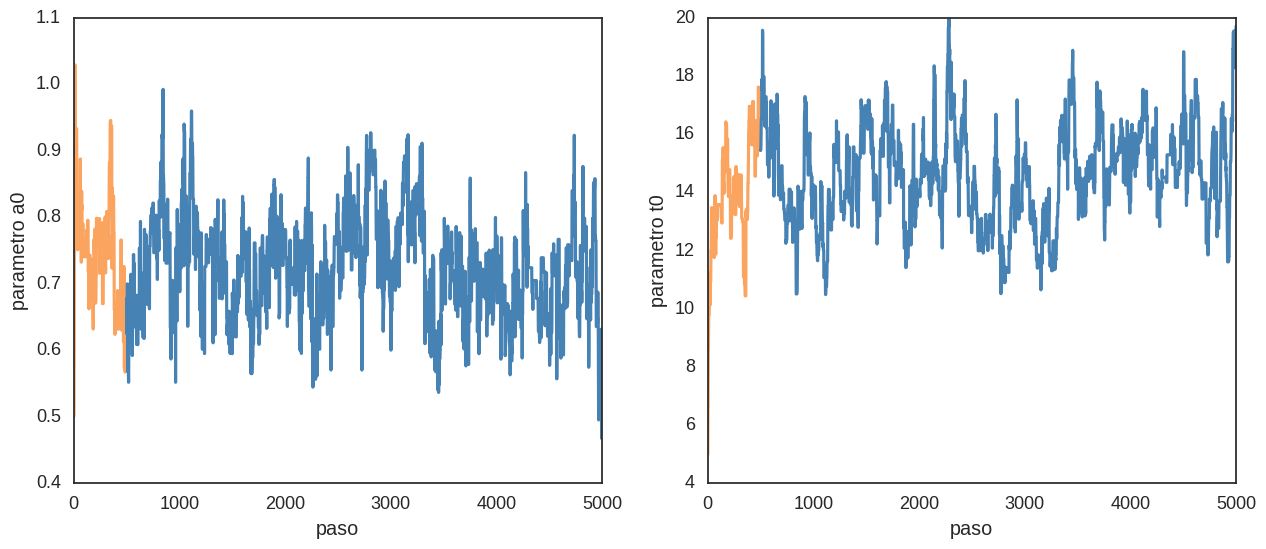

In [45]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(6)
f.set_figwidth(15)

i_out = np.linspace(0, Nburnt, Nburnt)
i_brn = np.linspace(Nburnt, Nsteps, Nsteps-Nburnt+1)

ax1.plot(i_out, par_a0_out, color='sandybrown')
ax1.plot(i_brn, par_a0_brn, color='steelblue')
ax1.set_xlabel('paso')
ax1.set_ylabel('parametro a0')

ax2.plot(i_out, par_t0_out, color='sandybrown')
ax2.plot(i_brn, par_t0_brn, color='steelblue')
ax2.set_xlabel('paso')
ax2.set_ylabel('parametro t0')

plt.show()

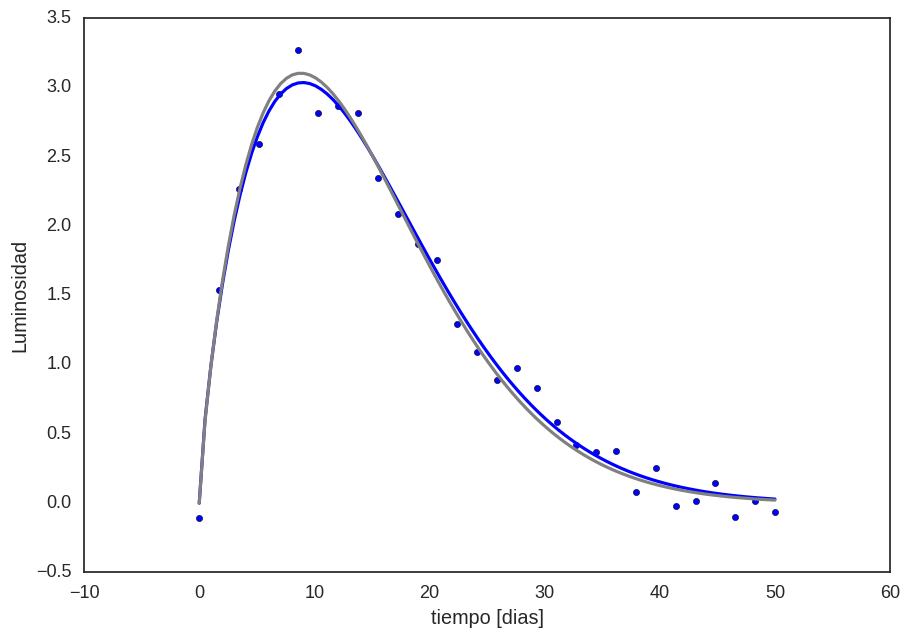

In [46]:
# Modelo del ajuste:
modelx = np.linspace(0, 50, 100)
modely = MODEL(modelx, a0_est, t0_est)  # <----- uso los parámetros estimados!
model_real = MODEL(modelx, a0_real, t0_real)  # <----- uso los parámetros estimados!


plt.plot(modelx,modely, color="blue")
plt.plot(modelx,model_real, color="grey")
plt.scatter(obsx,obsy)
plt.xlabel('tiempo [dias]')
plt.ylabel('Luminosidad')
plt.show()